In [ ]:
# @title 0. Cài đặt thư viện (BẮT BUỘC)
# 1. Cài Numpy bản cũ để tránh lỗi FastText
!pip install "numpy<2.0.0"

# 2. Cài các thư viện cần thiết khác
!pip install fasttext underthesea scikit-learn pandas matplotlib seaborn
!pip install transformers datasets accelerate torch

print("\n>>> ĐÃ CÀI ĐẶT XONG.")
print("⚠️ QUAN TRỌNG: Hãy vào menu 'Runtime' -> 'Restart session' (hoặc Khởi động lại phiên) ngay bây giờ, sau đó mới chạy các ô code bên dưới!")

  Using cached fasttext-0.9.3.tar.gz (73 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.4/978.4 kB 49.8 MB/s eta 0:00:00
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.4 MB/s eta 0:00:00
  Created wheel for fasttext: filename=fasttext-0.9.3-cp312-cp312-linux_x86_64.whl size=4498213 sha256=0b4e20fdfb835936e275e99220173d973efe38659a050487229b89740910f489
  Stored in directory: /root/.cache/pip/wheels/20/27/95/a7baf1b435f1cbde017cabdf1e9688526d2b0e929255a359c6
Successfully built fasttext

>>> ĐÃ CÀI ĐẶT XONG.
⚠️ QUAN TRỌNG: Hãy vào menu 'Runtime' -> 'Restart session' (hoặc Khởi động lại phiên) ngay bây giờ, sau đó mới chạy các ô code bên dưới!


In [ ]:
# @title 1 & 2. Tải dữ liệu và Tiền xử lý
import os
import re
import pandas as pd
from underthesea import word_tokenize
from google.colab import drive

# 1. Kết nối Google Drive
drive.mount('/content/drive')

# --- CẤU HÌNH ĐƯỜNG DẪN (QUAN TRỌNG) ---
# Hãy đảm bảo đường dẫn này CHÍNH XÁC với nơi bạn lưu file trong Drive
BASE_DIR = '/content/drive/MyDrive/UIT-VSFC'

def load_uit_vsfc(data_type):
    folder_path = os.path.join(BASE_DIR, data_type)
    sents_file = os.path.join(folder_path, 'sents.txt')
    sentiments_file = os.path.join(folder_path, 'sentiments.txt')

    # Kiểm tra file có tồn tại không trước khi đọc
    if not os.path.exists(sents_file):
        print(f"❌ LỖI: Không tìm thấy file tại: {sents_file}")
        return None

    with open(sents_file, 'r', encoding='utf-8') as f:
        sents = [s.strip() for s in f.readlines()]
    with open(sentiments_file, 'r', encoding='utf-8') as f:
        labels = [int(s.strip()) for s in f.readlines()]

    return pd.DataFrame({'text': sents, 'label': labels})

# 2. Tải dữ liệu
print(">>> Đang tải dữ liệu...")
train_df = load_uit_vsfc('train')
dev_df = load_uit_vsfc('dev')
test_df = load_uit_vsfc('test')

# Chỉ chạy tiếp nếu tải dữ liệu thành công
if train_df is not None:
    print(f"✅ Tải xong: Train ({len(train_df)}), Dev ({len(dev_df)}), Test ({len(test_df)})")

    # 3. Tiền xử lý (Clean + Tách từ)
    print(">>> Đang tiền xử lý (Clean & Tokenize)...")

    replace_list = {
        'ô kêi': 'ok', 'okie': 'ok', 'o kê': 'ok', 'okey': 'ok', 'ôkê': 'ok',
        'oki': 'ok', 'oke': 'ok', 'okay': 'ok', 'okê': 'ok',
        'tks': 'cảm ơn', 'thks': 'cảm ơn', 'thanks': 'cảm ơn', 'ths': 'cảm ơn', 'thank': 'cảm ơn',
        'kg': 'không', 'not': 'không', 'k': 'không', 'kh': 'không', 'kô': 'không', 'hok': 'không', 'ko': 'không', 'khong': 'không',
        'vs': 'với', 'wa': 'quá', 'wá': 'quá', 'j': 'gì', '“': ' ', '”': ' ', '"': ' ',
    }

    def preprocess_full(text):
        text = str(text).lower()
        for k, v in replace_list.items():
            text = text.replace(k, v)
        text = re.sub(r'[^a-záàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵđ0-9\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return word_tokenize(text, format="text")

    # Áp dụng
    train_df['text_clean'] = train_df['text'].apply(preprocess_full)
    test_df['text_clean'] = test_df['text'].apply(preprocess_full)

    # Gán biến cho các bước sau (Quan trọng)
    X_train = train_df['text_clean']
    y_train = train_df['label']
    X_test = test_df['text_clean']
    y_test = test_df['label']

    print("✅ Đã xử lý xong! Bạn có thể chạy tiếp Bước 3.")
else:
    print("⚠️ Dừng chương trình do không tải được dữ liệu. Hãy kiểm tra lại đường dẫn BASE_DIR.")

Mounted at /content/drive
>>> Đang tải dữ liệu...
✅ Tải xong: Train (11426), Dev (1583), Test (3166)
>>> Đang tiền xử lý (Clean & Tokenize)...
✅ Đã xử lý xong! Bạn có thể chạy tiếp Bước 3.


In [ ]:
# @title 3. Thực nghiệm các phương pháp Truyền thống
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Bảng lưu kết quả tổng hợp
results_table = []

def train_eval_traditional(name, vectorizer, clf):
    print(f"--- Đang chạy: {name} ---")
    # 1. Vector hóa
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # 2. Huấn luyện
    clf.fit(X_train_vec, y_train)

    # 3. Dự đoán
    y_pred = clf.predict(X_test_vec)

    # 4. Đánh giá
    acc = accuracy_score(y_test, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    print(f"✅ {name}: Accuracy = {acc:.4f}")
    results_table.append({'Model': name, 'Accuracy': acc, 'Precision': p, 'Recall': r, 'F1-Score': f1})

# Cấu hình Logistic Regression chung
lr_model = LogisticRegression(solver='lbfgs', max_iter=1000)

# 3.1 One-Hot Encoding
train_eval_traditional("One-Hot + LR",
                       CountVectorizer(binary=True, max_features=10000),
                       lr_model)

# 3.2 Bag of Words (BoW)
train_eval_traditional("BoW + LR",
                       CountVectorizer(binary=False, max_features=10000),
                       lr_model)

# 3.3 TF-IDF
train_eval_traditional("TF-IDF + LR",
                       TfidfVectorizer(max_features=10000),
                       lr_model)

--- Đang chạy: One-Hot + LR ---
✅ One-Hot + LR: Accuracy = 0.8831
--- Đang chạy: BoW + LR ---
✅ BoW + LR: Accuracy = 0.8816
--- Đang chạy: TF-IDF + LR ---
✅ TF-IDF + LR: Accuracy = 0.8834


In [ ]:
# @title 4. Thực nghiệm FastText (Thêm Precision & Recall)
import fasttext
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

print(">>> BẮT ĐẦU: FastText (Optimized) với đầy đủ chỉ số...")

# 1. Khởi tạo bảng kết quả nếu chưa có
if 'results_table' not in globals():
    results_table = []

# 2. Chuẩn bị dữ liệu định dạng FastText
def prepare_ft_data(text_series, label_series, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        for text, label in zip(text_series, label_series):
            f.write(f"__label__{label} {text}\n")

prepare_ft_data(X_train, y_train, 'train.ft')
prepare_ft_data(X_test, y_test, 'test.ft')

# 3. Huấn luyện (Cấu hình N-grams=3 để bắt ngữ cảnh tốt)
# Bạn có thể bật chế độ autotune nếu muốn (nhưng sẽ lâu hơn)
model_ft = fasttext.train_supervised(
    input='train.ft',
    wordNgrams=3,     # Quan trọng cho tiếng Việt
    lr=0.5,
    epoch=30,
    dim=100
)

# 4. Dự đoán
y_pred_ft = []
for text in X_test:
    pred_label = model_ft.predict(text)[0][0]
    y_pred_ft.append(int(pred_label.replace('__label__', '')))

# 5. TÍNH TOÁN ĐẦY ĐỦ CÁC CHỈ SỐ (Accuracy, Precision, Recall, F1)
acc = accuracy_score(y_test, y_pred_ft)
# average='weighted' giúp tính trung bình có trọng số cho bài toán đa lớp (3 lớp)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_ft, average='weighted')

print("\n" + "="*40)
print(f"✅ KẾT QUẢ CHI TIẾT FASTTEXT")
print("="*40)
print(f"   • Accuracy  (Độ chính xác): {acc:.4f}")
print(f"   • Precision (Độ chuẩn)    : {precision:.4f}")
print(f"   • Recall    (Độ phủ)      : {recall:.4f}")
print(f"   • F1-Score  (Trung hòa)   : {f1:.4f}")
print("="*40)

# 6. Cập nhật vào bảng tổng hợp (để vẽ biểu đồ sau này)
# Xóa kết quả cũ nếu có để tránh trùng lặp
results_table = [res for res in results_table if res['Model'] != 'FastText']
results_table.append({
    'Model': 'FastText',
    'Accuracy': acc,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

print(">>> Đã lưu đầy đủ kết quả vào bảng.")

>>> BẮT ĐẦU: FastText (Optimized) với đầy đủ chỉ số...

✅ KẾT QUẢ CHI TIẾT FASTTEXT
   • Accuracy  (Độ chính xác): 0.8869
   • Precision (Độ chuẩn)    : 0.8785
   • Recall    (Độ phủ)      : 0.8869
   • F1-Score  (Trung hòa)   : 0.8812
>>> Đã lưu đầy đủ kết quả vào bảng.


In [ ]:
# @title 5. Thực nghiệm Transformer (PhoBERT, viBERT, XLM-R...)
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import Dataset

# Tắt WandB log
os.environ["WANDB_DISABLED"] = "true"

# Danh sách model cần chạy
# Bạn có thể comment bớt dòng nếu muốn chạy nhanh hơn
transformers_models = {
    'PhoBERT': 'vinai/phobert-base',           # Tốt nhất cho tiếng Việt
    'viBERT': 'FPTAI/vibert-base-cased',       # Nhẹ hơn PhoBERT
    'mBERT': 'bert-base-multilingual-cased',   # Đa ngôn ngữ của Google
    'XLM-R': 'xlm-roberta-base'                # Đa ngôn ngữ mạnh của Facebook
}

# Hàm chuyển đổi dữ liệu sang định dạng HuggingFace
def convert_to_hg_dataset(X, y):
    return Dataset.from_dict({"text": list(X), "label": list(y)})

train_dataset = convert_to_hg_dataset(X_train, y_train)
test_dataset = convert_to_hg_dataset(X_test, y_test)

# Vòng lặp chạy từng model
for model_alias, model_name in transformers_models.items():
    print(f"\n>>> Đang xử lý: {model_alias} ({model_name}) ...")

    try:
        # 1. Load Tokenizer & Model
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

        # 2. Tokenize dữ liệu
        def tokenize_function(examples):
            return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

        tokenized_train = train_dataset.map(tokenize_function, batched=True)
        tokenized_test = test_dataset.map(tokenize_function, batched=True)

        # 3. Cấu hình huấn luyện (Giảm batch size để tránh tràn RAM)
        args = TrainingArguments(
            output_dir=f"./results_{model_alias}",
            num_train_epochs=3,              # Số vòng lặp
            per_device_train_batch_size=16,  # Batch size nhỏ
            per_device_eval_batch_size=16,
            eval_strategy="epoch",
            save_strategy="no",              # Không lưu checkpoint cho nhẹ ổ cứng
            learning_rate=2e-5,
            report_to="none"
        )

        # 4. Tạo Trainer
        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=tokenized_train,
            eval_dataset=tokenized_test,
            compute_metrics=lambda p: {"accuracy": accuracy_score(p.label_ids, p.predictions.argmax(-1))}
        )

        # 5. Train & Evaluate
        trainer.train()
        eval_result = trainer.evaluate()

        # 6. Lưu kết quả
        # Lấy thêm các chỉ số Precision/Recall/F1 thủ công để chính xác
        preds = trainer.predict(tokenized_test)
        y_pred_trans = preds.predictions.argmax(-1)
        p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred_trans, average='weighted')

        acc = eval_result['eval_accuracy']
        print(f"✅ {model_alias}: Accuracy = {acc:.4f}")
        results_table.append({'Model': model_alias, 'Accuracy': acc, 'Precision': p, 'Recall': r, 'F1-Score': f1})

        # 7. DỌN DẸP BỘ NHỚ (CỰC KỲ QUAN TRỌNG)
        del model, tokenizer, trainer
        torch.cuda.empty_cache()
        gc.collect()

    except Exception as e:
        print(f"⚠️ Lỗi khi chạy {model_alias}: {e}")
        torch.cuda.empty_cache()


>>> Đang xử lý: PhoBERT (vinai/phobert-base) ...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/11426 [00:00<?, ? examples/s]

Map:   0%|          | 0/3166 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.398500,0.300655,0.918825
2,0.217500,0.278383,0.933986
3,0.135400,0.298404,0.931459


✅ PhoBERT: Accuracy = 0.9315
⚠️ Lỗi khi chạy PhoBERT: name 'gc' is not defined

>>> Đang xử lý: viBERT (FPTAI/vibert-base-cased) ...


config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/581M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at FPTAI/vibert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/11426 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/581M [00:00<?, ?B/s]

Map:   0%|          | 0/3166 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.403600,0.380459,0.895452
2,0.262600,0.354835,0.904927
3,0.158900,0.393043,0.911876


✅ viBERT: Accuracy = 0.9119
⚠️ Lỗi khi chạy viBERT: name 'gc' is not defined

>>> Đang xử lý: mBERT (bert-base-multilingual-cased) ...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/11426 [00:00<?, ? examples/s]

Map:   0%|          | 0/3166 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.384000,0.342246,0.903032
2,0.248300,0.318834,0.913771
3,0.156400,0.354630,0.920088


✅ mBERT: Accuracy = 0.9201
⚠️ Lỗi khi chạy mBERT: name 'gc' is not defined

>>> Đang xử lý: XLM-R (xlm-roberta-base) ...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/11426 [00:00<?, ? examples/s]

Map:   0%|          | 0/3166 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.472700,0.377080,0.904927
2,0.280600,0.343441,0.919457
3,0.198900,0.355154,0.919457


✅ XLM-R: Accuracy = 0.9195
⚠️ Lỗi khi chạy XLM-R: name 'gc' is not defined


>>> BƯỚC 6: TỔNG HỢP VÀ TRỰC QUAN HÓA KẾT QUẢ

BẢNG XẾP HẠNG HIỆU NĂNG CÁC MÔ HÌNH
          Model  Accuracy  F1-Score  Precision    Recall
4       PhoBERT  0.931459  0.927135   0.927051  0.931459
6         mBERT  0.920088  0.915377   0.915684  0.920088
7         XLM-R  0.919457  0.912538   0.913582  0.919457
5        viBERT  0.911876  0.906321   0.906892  0.911876
3      FastText  0.886924  0.881156   0.878486  0.886924
2   TF-IDF + LR  0.883449  0.865492   0.879283  0.883449
0  One-Hot + LR  0.883133  0.875349   0.873340  0.883133
1      BoW + LR  0.881554  0.872310   0.870270  0.881554
------------------------------------------------------------


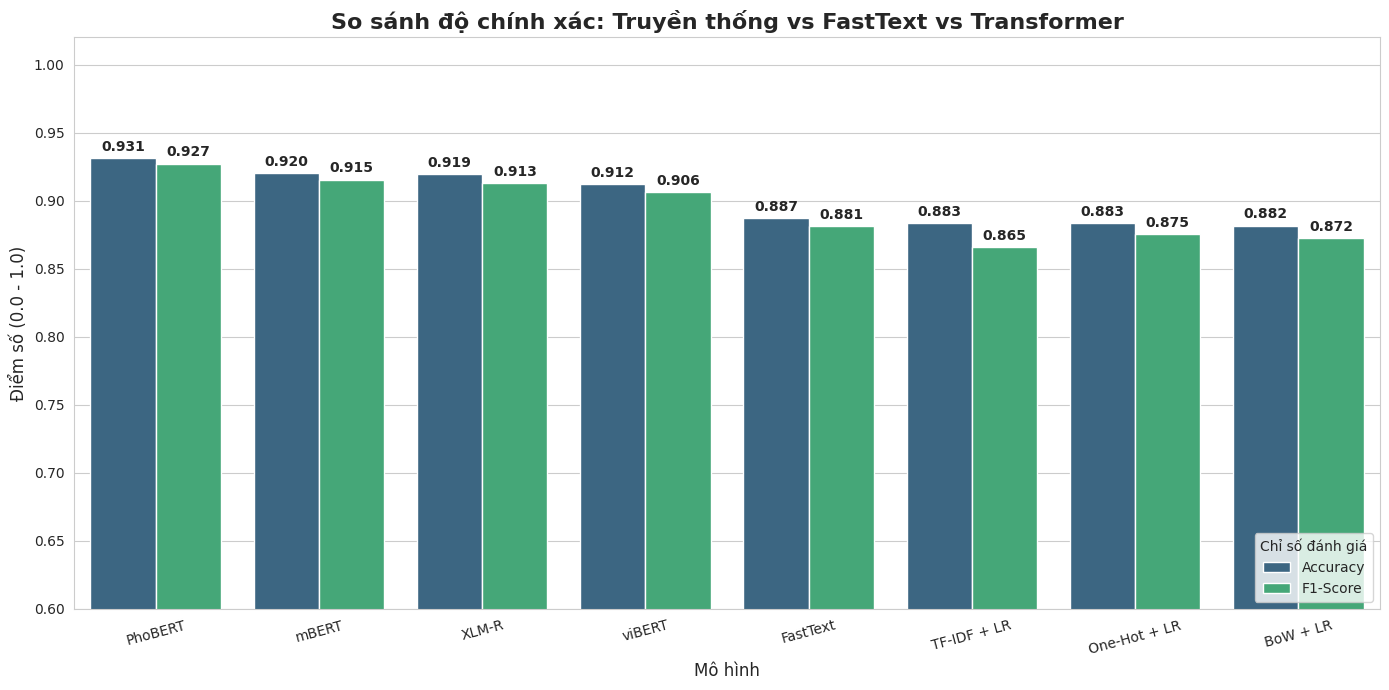


✅ Biểu đồ đã bao gồm tất cả các mô hình có trong bảng kết quả.


In [ ]:
# @title 6. Tổng hợp kết quả & Vẽ biểu đồ so sánh (ALL MODELS)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print(">>> BƯỚC 6: TỔNG HỢP VÀ TRỰC QUAN HÓA KẾT QUẢ")

# 1. Kiểm tra dữ liệu
if 'results_table' not in globals() or not results_table:
    print("⚠️ CHƯA CÓ DỮ LIỆU! Bạn cần chạy ít nhất một mô hình (Bước 3, 4 hoặc 5) trước.")
else:
    # 2. Tạo DataFrame tổng hợp
    df_res = pd.DataFrame(results_table).sort_values(by='Accuracy', ascending=False)

    # Hiển thị bảng số liệu chi tiết ra màn hình
    print("\n" + "="*60)
    print("BẢNG XẾP HẠNG HIỆU NĂNG CÁC MÔ HÌNH")
    print("="*60)
    print(df_res[['Model', 'Accuracy', 'F1-Score', 'Precision', 'Recall']])
    print("-" * 60)

    # 3. Vẽ biểu đồ so sánh (Grouped Bar Chart)
    plt.figure(figsize=(14, 7))
    sns.set_style("whitegrid")

    # Chuyển dữ liệu sang dạng 'long' để vẽ nhiều cột (Accuracy & F1)
    df_melted = df_res.melt(id_vars="Model",
                            value_vars=["Accuracy", "F1-Score"],
                            var_name="Metric",
                            value_name="Score")

    # Vẽ biểu đồ
    chart = sns.barplot(
        x="Model",
        y="Score",
        hue="Metric",
        data=df_melted,
        palette="viridis" # Màu sắc hiện đại
    )

    # 4. Trang trí biểu đồ chuẩn báo cáo
    plt.title("So sánh độ chính xác: Truyền thống vs FastText vs Transformer", fontsize=16, fontweight='bold')
    plt.ylabel("Điểm số (0.0 - 1.0)", fontsize=12)
    plt.xlabel("Mô hình", fontsize=12)
    plt.ylim(0.6, 1.02) # Giới hạn trục Y để thấy rõ sự chênh lệch (vì các model đều > 60%)
    plt.legend(title='Chỉ số đánh giá', loc='lower right')
    plt.xticks(rotation=15) # Xoay tên mô hình nhẹ cho dễ đọc

    # 5. Hiển thị con số chính xác trên đầu mỗi cột
    for container in chart.containers:
        chart.bar_label(container, fmt='%.3f', padding=3, fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()
    print("\n✅ Biểu đồ đã bao gồm tất cả các mô hình có trong bảng kết quả.")